In [45]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.spatial

np.random.seed( 2503865 ) # We'll set the random number generator's seed so everyone generates the exact same dataset

In [46]:
# Let's define 2 clusters defined by Gaussians (we'll call them clumps to avoid confusion later)
sigma = 0.05

clump1_N = 100
clump1_x = [ np.random.normal(loc=0.25,scale=sigma) for i in range(clump1_N) ]
clump1_y = [ np.random.normal(loc=0.75,scale=sigma) for i in range(clump1_N) ]

clump2_N = clump1_N
clump2_x = [ np.random.normal(loc=0.75,scale=sigma) for i in range(clump2_N) ]
clump2_y = [ np.random.normal(loc=0.25,scale=sigma) for i in range(clump2_N) ]

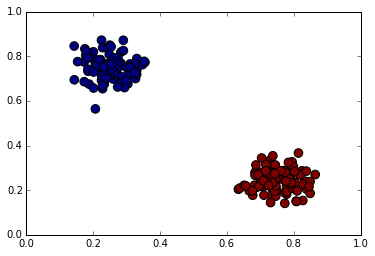

In [47]:
points_x = clump1_x + clump2_x
points_y = clump1_y + clump2_y
clump1_color = 0
clump2_color = 1
clump_area = 75
colors = [ clump1_color for i in range(clump1_N) ] + [ clump2_color for i in range(clump2_N) ]
areas = [ clump_area for i in range(clump1_N+clump2_N) ]

plt.scatter( points_x, points_y, c=colors, s=areas )

In [48]:
clump3_N = 5
clump3_x = [ np.random.normal(loc=0.5,scale=sigma) for i in range(clump3_N) ]
clump3_y = [ np.random.normal(loc=0.5,scale=sigma) for i in range(clump3_N) ]

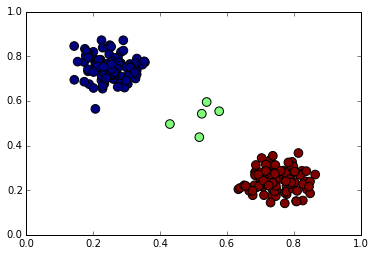

In [49]:
points_x = clump1_x + clump2_x + clump3_x
points_y = clump1_y + clump2_y + clump3_y
clump1_color = 0
clump2_color = 1
clump3_color = 0.5
clump_area = 75
colors = [ clump1_color for i in range(clump1_N) ] + [ clump2_color for i in range(clump2_N) ] + [ clump3_color for i in range(clump3_N) ]
areas = [ clump_area for i in range(clump1_N+clump2_N+clump3_N) ]

plt.scatter( points_x, points_y, c=colors, s=areas )
#plt.savefig('../images/instance_based_learning_001.png')

In [50]:
# NEW CELL 1: an exhaustive search implementation of kNN
# by Yunjie Lu, 2/3/2016

import math

# return the distance between two point
def distance(point1, point2):
    return math.hypot(point1[0] - point2[0], point1[1] - point2[1])

# return indexes of the point's k nearest neighbors using exhaustive search
def kNN_single_point(point, kNN_k):
    result = [(i, distance(point, dataset[i])) for i in range(len(dataset))]
    result.sort(key=lambda tup: tup[1]) 
    result = result[0:kNN_k]
    result = [(i[0]) for i in result]
    return result

dataset = list(zip(clump1_x + clump2_x, clump1_y + clump2_y))

query_result = kNN_single_point([0.5, 0.5], 10)
clump1_vote = np.sum( [ 1 for nbr_idx in query_result if nbr_idx <= clump1_N ] )
clump1_vote

7

In [51]:
# NEW CELL 2: exhaustive kNN search on a query_dataset (clump3)
# by Yunjie Lu, 2/3/2016

# return the k nearest neighbors of the query_dataset
def kNN(query_dataset, kNN_k):
    return [kNN_single_point(point, kNN_k) for point in query_dataset]

kNN_k = 11

query_dataset = list(zip(clump3_x, clump3_y))
query_result = kNN(query_dataset, kNN_k)

query_votes = [np.sum([1 for nbr_idx in row_result if nbr_idx < clump1_N]) for row_result in query_result]
query_votes

[0.0, 10, 2, 11, 11]

In [52]:
points_x = clump1_x + clump2_x
points_y = clump1_y + clump2_y

dataset = np.matrix( list( zip(points_x,points_y) ) )

kdtree = scipy.spatial.KDTree( dataset )

query_result = kdtree.query( [0.5, 0.5], k=10 )

clump1_vote = np.sum( [ 1 for nbr_idx in query_result[1] if nbr_idx <= clump1_N ] )

In [53]:
dataset = np.array( list( zip((clump1_x + clump2_x), (clump1_y + clump2_y)) ) )
kdtree = scipy.spatial.KDTree( dataset )

kNN_k = 11

query_dataset = np.array( list( zip(clump3_x,clump3_y) ) )
query_result = kdtree.query( query_dataset, k=kNN_k )

query_votes = [ np.sum( [ 1 for nbr_idx in row_result if nbr_idx < clump1_N ] ) for row_result in query_result[1] ]
query_votes

[0.0, 10, 2, 11, 11]

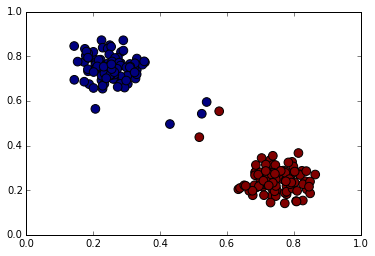

In [54]:
points_x = clump1_x + clump2_x + clump3_x
points_y = clump1_y + clump2_y + clump3_y
clump1_color = 0
clump2_color = 1
clump3_color = 0.5
clump_area = 75
colors = [ clump1_color for i in range(clump1_N) ] 
colors += [ clump2_color for i in range(clump2_N) ] 
colors += [ clump1_color if ( query_votes[i] > ( kNN_k / 2 ) ) else clump2_color for i in range(clump3_N) ]
areas = [ clump_area for i in range(clump1_N+clump2_N+clump3_N) ]

plt.scatter( points_x, points_y, c=colors, s=areas )
#plt.savefig('../images/instance_based_learning_002.png')

In [55]:
# Taken from some code for plotting a KD-tree in Python available here:
# https://salzis.wordpress.com/2014/06/28/kd-tree-and-nearest-neighbor-nn-search-2d-case/

from collections import namedtuple
from operator import itemgetter
from pprint import pformat

class Node(namedtuple('Node', 'location left_child right_child')):
 
    def __repr__(self):
        return pformat(tuple(self))
 
def viz_kdtree(point_list, depth=0):
    """ build K-D tree
    :param point_list list of input points
    :param depth      current tree's depth
    :return tree node
    """
 
    # assumes all points have the same dimension
    try:
        k = len(point_list[0])
    except IndexError:
        return None
 
    # Select axis based on depth so that axis cycles through
    # all valid values
    axis = depth % k
 
    # Sort point list and choose median as pivot element
    point_list.sort(key=itemgetter(axis))
    median = len(point_list) // 2         # choose median
 
    # Create node and construct subtrees
    return Node(
        location=point_list[median],
        left_child=viz_kdtree(point_list[:median], depth + 1),
        right_child=viz_kdtree(point_list[median + 1:], depth + 1)
    )

 
def plot_tree(tree, min_x, max_x, min_y, max_y, prev_node, branch, depth=0):
    """ plot K-D tree
    :param tree      input tree to be plotted
    :param min_x
    :param max_x
    :param min_y
    :param max_y
    :param prev_node parent's node
    :param branch    True if left, False if right
    :param depth     tree's depth
    :return tree     node
    """
 
    cur_node = tree.location         # current tree's node
    left_branch = tree.left_child    # its left branch
    right_branch = tree.right_child  # its right branch
 
    # set line's width depending on tree's depth
    if depth > len(line_width)-1:
        ln_width = line_width[len(line_width)-1]
    else:
        ln_width = line_width[depth]
 
    k = len(cur_node)
    axis = depth % k
 
    # draw a vertical splitting line
    if axis == 0:
 
        if branch is not None and prev_node is not None:
 
            if branch:
                max_y = prev_node[1]
            else:
                min_y = prev_node[1]
 
        plt.plot([cur_node[0],cur_node[0]], [min_y,max_y], linestyle='-', color='red', linewidth=ln_width)
 
    # draw a horizontal splitting line
    elif axis == 1:
 
        if branch is not None and prev_node is not None:
 
            if branch:
                max_x = prev_node[0]
            else:
                min_x = prev_node[0]
 
        plt.plot([min_x,max_x], [cur_node[1],cur_node[1]], linestyle='-', color='blue', linewidth=ln_width)
 
    # draw the current node
    plt.plot(cur_node[0], cur_node[1], 'ko')
 
    # draw left and right branches of the current node
    if left_branch is not None:
        plot_tree(left_branch, min_x, max_x, min_y, max_y, cur_node, True, depth+1)
 
    if right_branch is not None:
        plot_tree(right_branch, min_x, max_x, min_y, max_y, cur_node, False, depth+1)
 

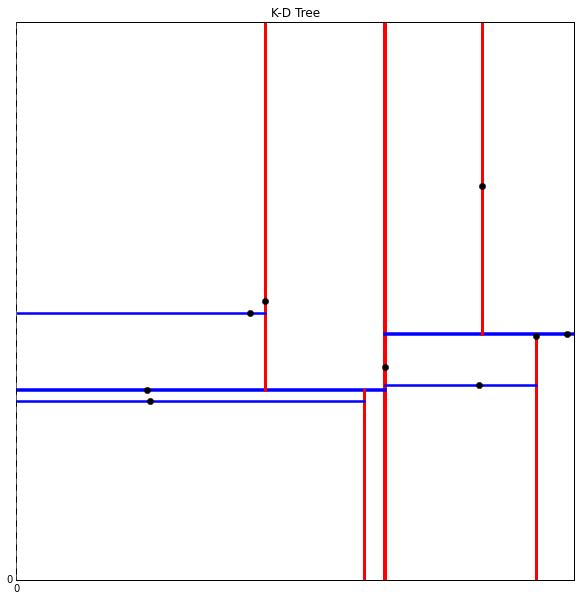

In [56]:
sigma = 0.25

clump4_N = 10 #500
clump4_x = [ np.random.normal(loc=0.5,scale=sigma) for i in range(clump4_N) ]
clump4_y = [ np.random.normal(loc=0.5,scale=sigma) for i in range(clump4_N) ]

vkdtree = viz_kdtree( list( zip(clump4_x, clump4_y) ) )

# line width for visualization of K-D tree
line_width = [4., 3.5, 3., 2.5, 2., 1.5, 1., .5, 0.3]

min_val = 0
max_val = 1
delta = 0

plt.figure("K-d Tree", figsize=(10., 10.))
plt.axis( [min_val-delta, max_val+delta, min_val-delta, max_val+delta] )
 
plt.grid(b=True, which='major', color='0.75', linestyle='--')
plt.xticks([i for i in range(min_val-delta, max_val+delta, 1)])
plt.yticks([i for i in range(min_val-delta, max_val+delta, 1)])
 
# draw the tree
plot_tree(vkdtree, min_val-delta, max_val+delta, min_val-delta, max_val+delta, None, None)
 
plt.title('K-D Tree')
#plt.show()
#plt.savefig('../images/instance_based_learning_003.png')

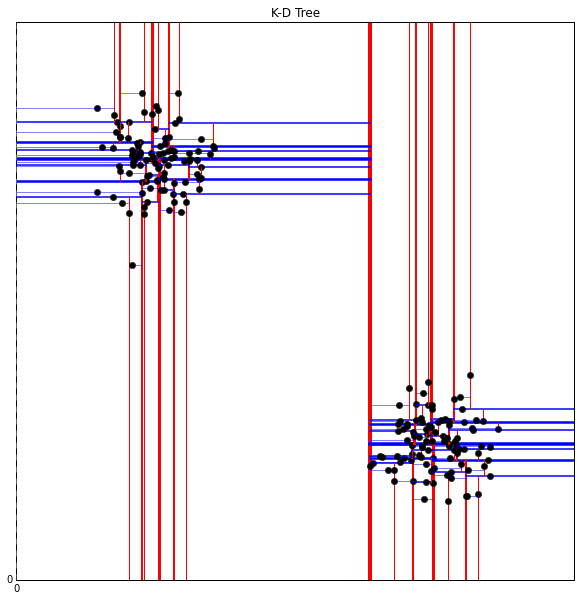

In [42]:
vkdtree = viz_kdtree( list( zip((clump1_x + clump2_x), (clump1_y + clump2_y)) ) )

# line width for visualization of K-D tree
line_width = [4., 3.5, 3., 2.5, 2., 1.5, 1., .5, 0.3]

min_val = 0
max_val = 1
delta = 0

plt.figure("K-d Tree", figsize=(10., 10.))
plt.axis( [min_val-delta, max_val+delta, min_val-delta, max_val+delta] )
 
plt.grid(b=True, which='major', color='0.75', linestyle='--')
plt.xticks([i for i in range(min_val-delta, max_val+delta, 1)])
plt.yticks([i for i in range(min_val-delta, max_val+delta, 1)])
 
# draw the tree
plot_tree(vkdtree, min_val-delta, max_val+delta, min_val-delta, max_val+delta, None, None)
 
plt.title('K-D Tree')
#plt.show()
#plt.savefig('../images/instance_based_learning_004.png')